In [114]:
%matplotlib notebook
%reload_ext autoreload
%autoreload

import os
import math
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import matplotlib.cm as cm
import numpy as np
import utils
import vectorutils as vu

# rc('font', **{'family':'sans-serif', 'sans-serif':['Helvetica'], 'size': 11})
# ## for Palatino and other serif fonts use:
# #rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

def plot_points(points, title = "", color = 'blue', size = 1.0, \
                axes = [0, 1, 2], lims = None, camera = [None, None], \
                label = 'f{:d}', knee_idx = None, alpha = None):
    """
    This function plots a set of points. If dimension is more than 3 then
    this function will use the axes specified in the axes paramter. By default,
    they are now x, y, and z axes.
    """
    fig, ax = None, None
    dim = len(points[0])
    if knee_idx is not None:
        knee_points = [points[i] for i in knee_idx]
        colors = [color[i] for i in knee_idx]
        sizes = [size[i] for i in knee_idx]
        other_idx = list(set([i for i in range(len(points))]) - set(knee_idx))
        other_points = [points[i] for i in other_idx]
        colors_ = [color[i] for i in other_idx]
        sizes_ = [size[i] for i in other_idx]
        p = list(zip(*knee_points))
        p_ = list(zip(*other_points))
    else:
        p = list(zip(*points))
        p_, colors_, sizes_ = None, None, None

    if dim < 3:
        fig, ax = plt.subplots()
        fig.suptitle(title)
        ax.set_xlabel(label.format(axes[0] + 1))
        ax.set_ylabel(label.format(axes[1] + 1))
        if lims is not None and len(lims) > 1:
            ax.set_xlim(lims[0][0], lims[0][1])
            ax.set_ylim(lims[1][0], lims[1][1])
        # plot others first
        if p_ is not None and colors_ is not None and sizes_ is not None:
            ax.scatter(p_[axes[0]], p_[axes[1]], \
                       color = colors_, marker = 'o', s = sizes_, \
                       alpha = 0.20 if alpha is None else alpha[0])
        # then plot knee
        ax.scatter(p[axes[0]], p[axes[1]], \
                   color = colors, marker = 'o', s = sizes, \
                   alpha = 1.0 if alpha is None else alpha[1])
    else:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        fig.suptitle(title)
        ax.set_xlabel(label.format(axes[0] + 1))
        ax.set_ylabel(label.format(axes[1] + 1))
        ax.set_zlabel(label.format(axes[2] + 1))
        if lims is not None and len(lims) > 2:
            ax.set_xlim(lims[0][0], lims[0][1])
            ax.set_ylim(lims[1][0], lims[1][1])
            ax.set_zlim(lims[2][0], lims[2][1])
        ax.view_init(elev = camera[0], azim = camera[1])
        # plot others first
        if p_ is not None and colors_ is not None and sizes_ is not None:
            ax.scatter(p_[axes[0]], p_[axes[1]], p_[axes[2]], \
                       color = colors_, marker = 'o', s = sizes_, \
                       alpha = 0.20 if alpha is None else alpha[0])
        # then plot knee
        ax.scatter(p[axes[0]], p[axes[1]], p[axes[2]], \
                   color = colors, marker = 'o', s = sizes, \
                   alpha = 1.0 if alpha is None else alpha[1])
    return (fig, ax)
        
def make_scaffold(m, layers, ax, label = "f{:d}"):
    """
    If the Palette visualization needs to show the scaffolding for the RadVis, this
    function will do all the necessary stuffs to show the scaffold.
    """
    # calculate the coordinates of all polygon corners.
    S = [[math.cos(t), math.sin(t)] for t in [2.0 * math.pi * (i/float(m)) for i in range(m)]]
    for z in layers:
        # draw polygons
        for i in range(0, len(S)-1):
            # draw one polygon line
            ax.plot([S[i][0], S[i + 1][0]], [S[i][1], S[i + 1][1]], zs = [z, z], \
                    c = 'gray', alpha = 0.15 * len(S), linewidth = 1.0)
            # draw a pair of polygon points
            ax.scatter(S[i][0], S[i][1], zs = z, color = 'gray', marker = 'o', \
                       s = 20.0, alpha = 1.0)
        # last polygon line
        ax.plot([S[len(S) - 1][0], S[0][0]], [S[len(S) - 1][1], S[0][1]], zs = [z, z], \
                c = 'gray', alpha = 0.15 * len(S), linewidth = 1.0)
        # last pair of polygon points
        ax.scatter(S[len(S) - 1][0], S[len(S) - 1][1], zs = z, \
                   c = 'gray', marker = 'o', s = 20.0, alpha = 1.0)
        # now put all the corner labels, like f1, f2, f3, ... etc.
        for xy, name in zip(S, [label.format(i+1) for i in range(m)]):
            if xy[0] < 0.0 and xy[1] < 0.0:
                ax.text(xy[0] - 0.025, xy[1] - 0.025, z = z, s = name, ha = 'right', \
                        va = 'top', size = 'small')
            elif xy[0] < 0.0 and xy[1] >= 0.0: 
                ax.text(xy[0] - 0.025, xy[1] + 0.025, z = z, s = name, ha = 'right', \
                        va = 'bottom', size = 'small')
            elif xy[0] >= 0.0 and xy[1] < 0.0:
                ax.text(xy[0] + 0.025, xy[1] - 0.025, z = z, s = name, ha = 'left', \
                        va = 'top', size = 'small')
            elif xy[0] >= 0.0 and xy[1] >= 0.0:
                ax.text(xy[0] + 0.025, xy[1] + 0.025, z = z, s = name, ha = 'left', \
                        va = 'bottom', size = 'small')

def palette_viz(coords, knee_idx = None, title = "", m = 3, color = None, size = 1.0, \
                camera = [None, None], scaffold = True, label = "f{:d}", alpha = None):
    """
    The Palette visualization method. This function assumes
    the palette coordinate values are already computed.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev = camera[0], azim = camera[1])
    fig.suptitle(title)
    if knee_idx is not None:
        knee_coords = [coords[i] for i in knee_idx]
        knee_color = [color[i] for i in knee_idx]
        knee_size = [size[i] for i in knee_idx]
        other_idx = list(set([i for i in range(len(coords))]) - set(knee_idx))
        other_coords = [coords[i] for i in other_idx]
        other_color = [color[i] for i in other_idx]
        other_size = [size[i] for i in other_idx]
        # plot others first
        [u, v, w_] = list(zip(*other_coords))
        ax.scatter(u, v, w_, marker = 'o', s = other_size, color = other_color, \
                   alpha = 0.10 if alpha is None else alpha[0])
        # then knee points
        [u, v, w] = list(zip(*knee_coords))
        ax.scatter(u, v, w, marker = 'o', s = knee_size, color = knee_color, \
                   alpha = 0.8 if alpha is None else alpha[1])
        layers = list(set(w).union(set(w_)))
    else:
        [u, v, w] = list(zip(*coords))
        layers = list(set(w))
        ax.scatter(u, v, w, marker = 'o', s = size, color = color)        
        
    if scaffold:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.set_axis_off()
        make_scaffold(m, layers, ax, label)
    return (fig, ax)

# Different point attribute modifiers
def get_centroid(points):
    cols = list(zip(*points))
    centroid = []
    for col in cols:
        centroid.append(sum(col)/len(col))
    return centroid

def recolor_by_centroid(points, factor = 1.5):
    """
    Color the points according to the distance from the centroid.
    """
    c = get_centroid(points)
    cdist = []
    maxcdist, mincdist = float('-inf'), float('inf')
    for point in points:
        d = math.sqrt(sum([(p - c[i])*(p - c[i]) \
                           for i, p in enumerate(point)]))
        maxcdist = d if d >= maxcdist else maxcdist
        mincdist = d if d <= mincdist else mincdist
        cdist.append(d)
    color = [cm.winter_r(((v - mincdist)/(maxcdist - mincdist)) * factor) for v in cdist]
    return color
 
def rescale_by_knee(mu):
    """
    Change the sizes of the points according to the trade-off values.
    """
    nonzero_mu = [v for v in mu if v > 0.0]
    min_mu = min(nonzero_mu)
    max_mu = max(nonzero_mu)
    mu_ = vu.normalize(mu, min_mu, max_mu)
    mean_mu = math.fsum(mu_)/len(mu_)
    sd_mu = math.sqrt(math.fsum([(m - mean_mu)**2 for m in mu_])/(len(mu_) - 1))
    # sizes = [15.0 for _ in range(len(mu))]
    sizes = [((m + 0.01) * 100.0) for m in mu_]
    return sizes

def recolor_by_knee(size, color):
    """
    Recolor the points according to the trade-off values. This function
    will change the color of the points with higher trade-offs to 
    dark red.
    """
    max_sz = max(size)
    min_sz = min(size)
    mean_sz = math.fsum(size)/len(size)
    sd_sz = math.sqrt(math.fsum([((s - mean_sz) ** 2) for s in size])/(len(size) - 1))
    knee_idx = [i for i,s in enumerate(size) if s > (mean_sz + 3.0 * sd_sz)]
    knee_sizes = [size[i] for i in knee_idx]
    min_knee = min(knee_sizes)
    max_knee = max(knee_sizes)
#     print("max_sz:", max_sz, "min_sz:", min_sz, "mean_sz:", mean_sz, "sd_sz:", sd_sz)
#     print("knee_idx:", knee_idx)
#     print("min_knee:", min_knee, "max_knee:", max_knee)
    for i in range(len(color)):
        if i in knee_idx:
            knee_range = max_knee - min_knee
            knee_range = 0.0 # we are not doing this anymore.
            if knee_range > 0.0:
                color[i] = cm.Reds(((size[i] - min_knee) / knee_range) * 2.5)
            else:
                color[i] = cm.Reds(2.5)
    return (color, knee_idx)

def recolor_by_cv(cv):
    """
    This function will change the color of the points
    according to the total constraint violation value
    of each point.
    """
    color = [cm.cool(v * 1.0) for v in cv]
    return color

def recolor_by_layers(points, layers, seq = ['red', 'green']):
    """
    This function will change the color of the points
    according to the sequence of the layers. The color
    sequence is given in the seq variable.
    """
    colors = [''] * len(points)
    for i,layer in enumerate(layers):
        color = seq[i % len(seq)]
        for idx in layer:
            colors[idx] = color
    return colors

def recolor_by_labels(labels, dtype = 'float'):
    colors = [''] * len(labels)
    if dtype == 'float':
        lb = min(labels)
        ub = max(labels)
        vals = vu.normalize(labels, lb, ub)
        for i in range(len(vals)):
            colors[i] = cm.Reds(vals[i] * 2.5)
    elif dtype == 'str' or dtype == 'int':
        seq = ['red', 'green', 'blue', 'purple', 'orange', 'yellow', 'brown', 'pink', 'grey']
        unique_labels = list(set(labels))
        for i,name in enumerate(labels):
            colors[i] = seq[unique_labels.index(name) % len(seq)]      
    return colors

In [140]:
# Do all these plots with centroid based coloring

# prefix = "data/spherical/spherical-3d-norm"
# prefix = "data/spherical/spherical-4d-norm"
# prefix = "data/spherical/spherical-8d-norm"

# prefix = "data/knee/knee-3d-norm"
# prefix = "data/knee/knee-4d-norm"
# prefix = "data/knee/knee-8d-norm"

# prefix = "data/line/line-3d-norm"
# prefix = "data/line/line-4d-norm"
# prefix = "data/line/line-6d-norm"
# prefix = "data/line/line-8d-norm"

# prefix = "data/carcrash/carcrash-3d-norm"
# prefix = "data/carcrash-c1/carcrash-c1-3d-norm"
# prefix = "data/carcrash-c2/carcrash-c2-3d-norm"
# prefix = "data/carcrash/carcrash-c1/carcrash-c1-3d-norm"
# prefix = "data/carcrash/carcrash-c2/carcrash-c2-3d-norm"

# Do all these plots with constraint based coloring

# prefix = "data/knee-const/knee-const-3d-norm"
# prefix = "data/knee-const/knee-const-4d-norm"
# prefix = "data/knee-const/knee-const-8d-norm"

# prefix = "data/knee-const-mod/knee-const-mod-3d-norm"
# prefix = "data/knee-const-mod/knee-const-mod-4d-norm"

# prefix = "data/isolated/isolated-3d-norm"
# prefix = "data/isolated/isolated-4d-norm"
# prefix = "data/isolated/isolated-8d-norm"

# prefix = "data/c2dtlz2/c2dtlz2-3d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-4d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-5d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-8d-norm"

# prefix = "data/c2dtlz2/c2dtlz2-c1/c2dtlz2-c1-3d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-c2/c2dtlz2-c2-3d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-c3/c2dtlz2-c3-3d-norm"
# prefix = "data/c2dtlz2/c2dtlz2-c4/c2dtlz2-c4-3d-norm"

# prefix = "data/gaa-das/gaa-das-10d-norm"
# prefix = "data/gaa-lhs/gaa-lhs-10d-norm"
# prefix = "data/gaa-lhs/gaa-lhs-c1/gaa-lhs-c1-10d-norm"
# prefix = "data/gaa-lhs/gaa-lhs-c2/gaa-lhs-c2-10d-norm"
# prefix = "data/gaa-lhs/gaa-lhs-c3/gaa-lhs-c3-10d-norm"

# some ML data sets
# prefix = "data/airofoil/airofoil-5d-norm"
# prefix = "data/banknote/banknote-4d-norm"
# prefix = "data/blood/blood-4d-norm"
# prefix = "data/cccp/cccp-4d-norm"
# prefix = "data/concrete/concrete-8d-norm"
# prefix = "data/iris/iris-4d-norm"
# prefix = "data/mammogram/mammogram-5d-norm"
# prefix = "data/wil/wil-7d-norm"
prefix = "data/yeast/yeast-8d-norm"

# do visualization based on distance from the centroid?
docentroid = False

fname = prefix.split('/')[-1].split('-norm')[0]

points = utils.load(prefix + ".out")
mu = [v[0] if len(v) == 1 else v for v in utils.load(prefix + "-mu.out")]

cvfilepath = prefix.split('.')[0].split('-norm')[0] + "-cv.out"
if not docentroid and os.path.exists(cvfilepath):
    cv = [v[0] if len(v) == 1 else v for v in utils.load(cvfilepath)]
    [low, up] = vu.get_bound(cv)
    cv = vu.normalize(cv, low, up)
    color = recolor_by_cv(cv)
else:
    color = recolor_by_centroid(points)

size = rescale_by_knee(mu)
(color, knee_idx) = recolor_by_knee(size, color)

# dtype = 'float'
# dtype = 'int'
dtype = 'str'
classfilepath = '/'.join(prefix.split('/')[0:2]) + '/' + fname + "-class.out"
if os.path.exists(classfilepath):
    labels = [v[0] if len(v) == 1 else v for v in utils.load(classfilepath, dtype = dtype)]
    color = recolor_by_labels(labels, dtype = dtype)
    size = [5.0 for _ in range(len(points))]

# some camera angles for better visualization
camera = {"spherical-3d": [32, 20], "spherical-4d": [32, 20], "spherical-8d": [32, 20], \
          "knee-3d": [19, -46], "knee-4d": [19, -46], "knee-8d": [19, -106], \
          "knee-const-3d": [25, 9], "knee-const-4d": [17, -24], "knee-const-8d": [11, -31], \
          "knee-const-mod-3d": [25, 9], "knee-const-mod-4d": [17, -24], "knee-const-mod-8d": [11, -31], \
          "isolated-3d": [32, 20], "isolated-4d": [8, -64], "isolated-8d": [14, -112], \
          "line-3d": [None, None], "line-4d": [None, None], "line-6d": [None, None], "line-8d": [None, None], \
          "c2dtlz2-3d": [32, 20], "c2dtlz2-4d": [37, -39], "c2dtlz2-5d": [37, -39], "c2dtlz2-8d": [25, -39], \
          "c2dtlz2-c1-3d": [32, 20], "c2dtlz2-c2-3d": [32, 20], "c2dtlz2-c3-3d": [32, 20], \
          "c2dtlz2-c4-3d": [32, 20], \
          "carcrash-3d": [46, 41], "carcrash-c1-3d": [30, 30,], "carcrash-c2-3d": [24, 64], \
          "gaa-das-10d": [22, -40], "gaa-lhs-10d": [22, -40], \
          "gaa-lhs-c1-10d": [7, -51], "gaa-lhs-c2-10d": [7, -51], "gaa-lhs-c3-10d": [7, -51], \
          "iris-4d": [None, None], "cccp-4d": [None, None], "airofoil-5d": [None, None], "wil-7d": [None, None], \
          "yeast-8d": [None, None], "concrete-8d": [None, None], "banknote-4d": [None, None], \
          "mammogram-5d": [None, None], "blood-4d": [None, None]}

# alpha = [0.2, 0.8]
alpha = [1.0, 1.0]
# alpha = None
# use the original obj values for scatter plot.
points_orig = utils.load(prefix.split('-norm')[0] + ".out")
(fig, ax) = plot_points(points_orig, size = size, color = color, \
                        camera = camera[fname], knee_idx = knee_idx, alpha = alpha)

plt.show()
outfile_name = prefix + "-scatter.pdf"
plt.savefig(outfile_name, transparent = False)

ValueError: invalid literal for int() with base 10: 'MIT'

<IPython.core.display.Javascript object>


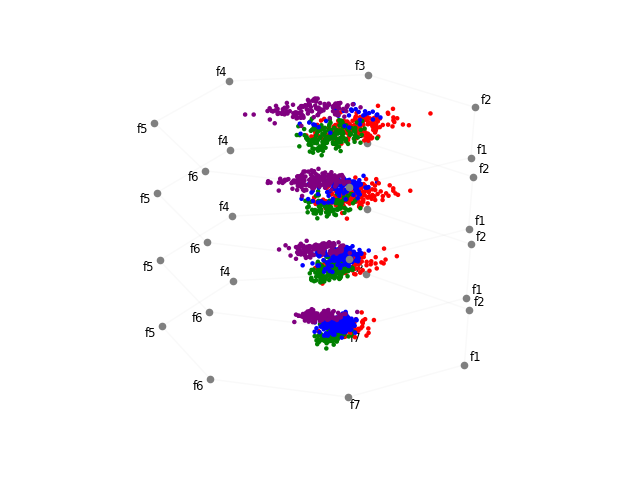

In [136]:
# plots for ieee-tec
# some camera angles for better visualization
camera = {"spherical-3d": [20, -98], "spherical-4d": [21, -67], "spherical-8d": [18, 158], \
          "knee-3d": [26, -52], "knee-4d": [18, -21], "knee-8d": [16, -168], \
          "knee-const-3d": [44, -50], "knee-const-4d": [23, 10], "knee-const-8d": [23, -178], \
          "knee-const-mod-3d": [44, -50], "knee-const-mod-4d": [23, 10], "knee-const-mod-8d": [23, -178], \
          "isolated-3d": [29, -76], "isolated-4d": [24, -161], "isolated-8d": [26, -109], \
          "line-3d": [None, None], "line-4d": [37, -61], "line-6d": [25, -7], "line-8d": [30, 13],\
          "c2dtlz2-3d": [36, -45], "c2dtlz2-4d": [23, -67], "c2dtlz2-5d": [24, -29], "c2dtlz2-8d": [26, -69], \
          "c2dtlz2-c1-3d": [36, -45], "c2dtlz2-c2-3d": [36, -45], "c2dtlz2-c3-3d": [36, -45], \
          "c2dtlz2-c4-3d": [36, -45], \
          "carcrash-3d": [24, -58], "carcrash-c1-3d": [25, 41], "carcrash-c2-3d": [19, -38], \
          "gaa-das-10d": [27, -105], "gaa-lhs-10d": [27, -105], \
          "gaa-lhs-c1-10d": [27, -105], "gaa-lhs-c2-10d": [27, -105], "gaa-lhs-c3-10d": [27, -105], \
          "iris-4d": [None, None], "cccp-4d": [None, None], "airofoil-5d": [None, None], "wil-7d": [None, None], \
          "yeast-8d": [None, None], "concrete-8d": [None, None], "banknote-4d": [None, None], \
          "mammogram-5d": [None, None], "blood-4d": [None, None]}

palette_coords = utils.load(prefix + "-palette.out")
outfile_name = prefix + "-palette.pdf"

(fig, ax) = palette_viz(palette_coords, knee_idx, m = len(points[0]), \
                        color = color, size = size, camera = camera[fname], alpha = alpha)
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
plt.show()
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


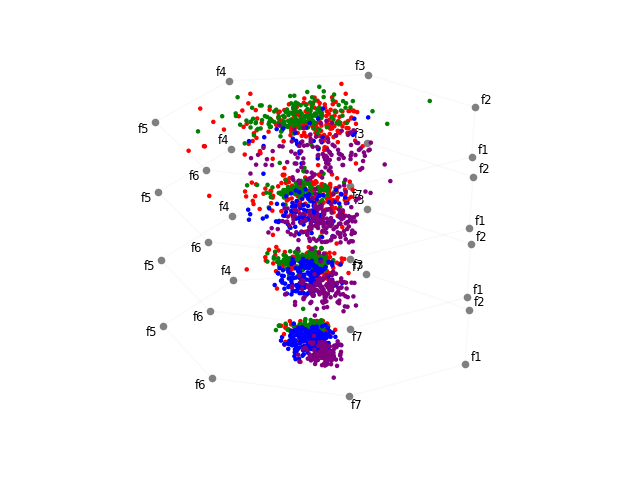

In [137]:
palette_coords = utils.load(prefix + "-palette-polar.out")
outfile_name = prefix + "-palette-polar.pdf"

(fig, ax) = palette_viz(palette_coords, knee_idx, m = len(points[0]), \
                        color = color, size = size, camera = camera[fname], alpha = alpha)
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
plt.show()
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


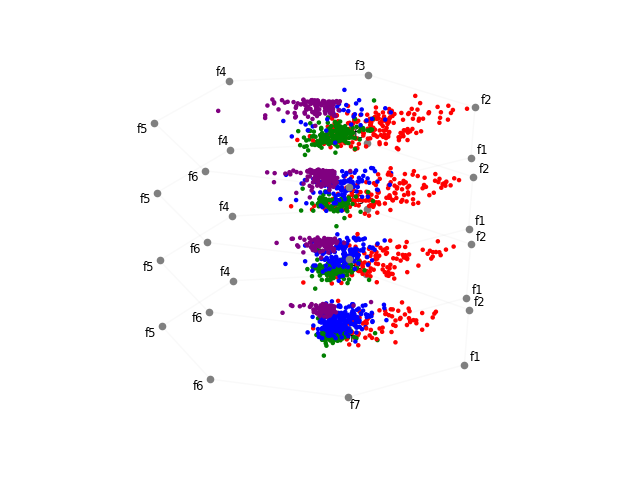

In [138]:
palette_coords = utils.load(prefix + "-palette-logistic.out")
outfile_name = prefix + "-palette-logistic.pdf"

(fig, ax) = palette_viz(palette_coords, knee_idx, m = len(points[0]), \
                        color = color, size = size, camera = camera[fname], alpha = alpha)
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
plt.show()
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)

<IPython.core.display.Javascript object>


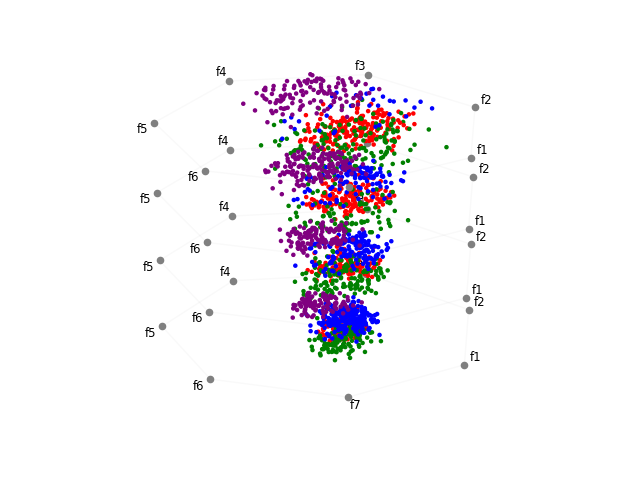

In [139]:
palette_coords = utils.load(prefix + "-palette-star.out")
outfile_name = prefix + "-palette-star.pdf"

(fig, ax) = palette_viz(palette_coords, knee_idx, m = len(points[0]), \
                        color = color, size = size, camera = camera[fname], alpha = alpha)
fig.subplots_adjust(left = 0, bottom = 0, right = 1, top = 1, wspace = 0, hspace = 0)
plt.show()
plt.savefig(outfile_name, transparent = False, bbox_inches = 'tight', pad_inches = 0)